In [1]:
%load_ext dotenv
%dotenv
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import boto3
from warnings import filterwarnings
filterwarnings("ignore")
import os
os.environ["PYTHONWARNINGS"] = "ignore"

s3_client = boto3.client(
    's3',
    endpoint_url='https://storage.yandexcloud.net',
    aws_access_key_id=os.getenv('AWS_ACCESS_KEY_ID'),
    aws_secret_access_key=os.getenv('AWS_SECRET_ACCESS_KEY'),
)
BUCKET_NAME = 'tnn-hse-medtech'
DATASET_DIR = 'datasets/'

cannot find .env file


Загружаем обработанный список изобрадений

In [2]:
data = pd.read_csv('normalized_data.csv')

In [3]:
data.head()

,expert,file_id,severity,relative_path
0,MedicalExpert-I,c7284c66fa8ec0ab4594e5dcd44866f408238f685e999e...,0,MedicalExpert-I/0Normal/NormalG0 (1).png
1,MedicalExpert-I,4a547b94fe02a7565beb21aa9195f4deffe831086da240...,0,MedicalExpert-I/0Normal/NormalG0 (10).png
2,MedicalExpert-I,ca8a296d1e15e0ed84c1ab82440426f28cd0582c19964f...,0,MedicalExpert-I/0Normal/NormalG0 (100).png
3,MedicalExpert-I,6f8bb6bbf0f4def4fdbe1a486064e47eefed0fa832246c...,0,MedicalExpert-I/0Normal/NormalG0 (101).png
4,MedicalExpert-I,d3c8f051ee6c5f59dff4657b7c007860be652e313d85ab...,0,MedicalExpert-I/0Normal/NormalG0 (102).png


Скачиваем файлы на диск, чтобы дальше обрабатывать

In [7]:
from pathlib import Path

from dataclasses import dataclass
from concurrent.futures import ThreadPoolExecutor
from tqdm.notebook import tqdm
import PIL

IMAGE_DIRECTORY = Path('.') / 'images'

@dataclass()
class Metadata:
    severity: int
    relative_path: str
    path: Path
    width: int
    height: int
    size: int

def handle_file(item) -> Metadata:
    path = IMAGE_DIRECTORY / item.relative_path
    path.parent.mkdir(parents=True, exist_ok=True)
    s3_client.download_file(BUCKET_NAME, f'{DATASET_DIR}{item.relative_path}', str(path))
    with PIL.Image.open(str(path)) as im:
        width, height = im.size
    return Metadata(item.severity, item.relative_path, path, width, height, size=path.stat().st_size)

raw_data = []
with ThreadPoolExecutor(max_workers=100) as pool:
    for item in tqdm(pool.map(handle_file, data.itertuples(), chunksize=1), total=len(data)):
        raw_data.append(item)

  0%|          | 0/3278 [00:00<?, ?it/s]

In [10]:
df = pd.DataFrame(raw_data)
df.sample(5)

,severity,relative_path,path,width,height,size
2839,2,MedicalExpert-II/2Mild/MildG2 (89).png,images/MedicalExpert-II/2Mild/MildG2 (89).png,300,162,29282
2112,0,MedicalExpert-II/0Normal/NormalG0 (72).png,images/MedicalExpert-II/0Normal/NormalG0 (72).png,300,162,32798
2759,2,MedicalExpert-II/2Mild/MildG2 (225).png,images/MedicalExpert-II/2Mild/MildG2 (225).png,640,161,64217
665,1,MedicalExpert-I/1Doubtful/DoubtfulG1 (245).png,images/MedicalExpert-I/1Doubtful/DoubtfulG1 (2...,300,162,31743
1984,0,MedicalExpert-II/0Normal/NormalG0 (413).png,images/MedicalExpert-II/0Normal/NormalG0 (413)...,300,162,31667


Смотрим на респределение по разрешениям

In [11]:
df.groupby(['width', 'height']).size()

width  height
300    162       2916
640    161        362
dtype: int64

Отделяем снимки с одним коленом в отдельный датасет

In [12]:
double = df[df.width == 640]
single = df[df.width == 300]
single

,severity,relative_path,path,width,height,size
0,0,MedicalExpert-I/0Normal/NormalG0 (1).png,images/MedicalExpert-I/0Normal/NormalG0 (1).png,300,162,31193
1,0,MedicalExpert-I/0Normal/NormalG0 (10).png,images/MedicalExpert-I/0Normal/NormalG0 (10).png,300,162,34614
2,0,MedicalExpert-I/0Normal/NormalG0 (100).png,images/MedicalExpert-I/0Normal/NormalG0 (100).png,300,162,33982
3,0,MedicalExpert-I/0Normal/NormalG0 (101).png,images/MedicalExpert-I/0Normal/NormalG0 (101).png,300,162,28115
4,0,MedicalExpert-I/0Normal/NormalG0 (102).png,images/MedicalExpert-I/0Normal/NormalG0 (102).png,300,162,31167
...,...,...,...,...,...,...
3273,4,MedicalExpert-II/4Severe/SevereG4 (95).png,images/MedicalExpert-II/4Severe/SevereG4 (95).png,300,162,28841
3274,4,MedicalExpert-II/4Severe/SevereG4 (96).png,images/MedicalExpert-II/4Severe/SevereG4 (96).png,300,162,32913
3275,4,MedicalExpert-II/4Severe/SevereG4 (97).png,images/MedicalExpert-II/4Severe/SevereG4 (97).png,300,162,34643
3276,4,MedicalExpert-II/4Severe/SevereG4 (98).png,images/MedicalExpert-II/4Severe/SevereG4 (98).png,300,162,30874


In [16]:
single.severity.value_counts()

0    892
1    880
4    412
2    382
3    350
Name: severity, dtype: int64

Переносим в отдельный каталог

In [13]:
SINGLE_PATH = Path('.') / 'single'
for item in single.itertuples():
    directory = SINGLE_PATH / str(item.severity)
    directory.mkdir(parents=True, exist_ok=True)
    new_path =  directory / Path(item.path.name)
    Path(item.path).rename(new_path)

Устанавливаем нужный набор библиотек для обучения автоэнкодера

In [19]:
%pip install torch torchvision

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [15]:
%pip install torchsummary opencv-python

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [27]:
import torch
from torch import nn, optim
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.transforms import v2
from pathlib import Path
from PIL import Image
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

def loader(path):
    """
    Часть изображений сохранено в 10-битном формате
    а Pillow не поддерживает такое. Поэтому загружаем в через
    OpenCV и понижаем битность. 
    """
    image = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if image.dtype == np.uint16:
        image = (image / 256)
    img = Image.fromarray(image.astype("uint8"))
    return img


SINGLE_PATH = Path('.') / 'single'
batch_size=256

# Добавляем аугментацию, чтобы увеличить размер датасета
train_transforms = transforms.Compose([
    transforms.v2.Grayscale(num_output_channels=1),
    transforms.v2.RandomHorizontalFlip(p=0.5),
    transforms.v2.RandomInvert(),
    v2.ToImageTensor(),
    transforms.v2.ConvertImageDtype(),
    transforms.v2.Normalize((0.5,), (0.5,))
])
test_transforms = transforms.Compose([
    transforms.v2.Grayscale(num_output_channels=1),
    v2.ToImageTensor(),
    transforms.v2.ConvertImageDtype(),
    transforms.v2.Normalize((0.5,), (0.5,))
])
dataset = ImageFolder(SINGLE_PATH, transform=train_transforms, loader=loader)
test_dataset = ImageFolder(SINGLE_PATH, transform=test_transforms, loader=loader)
# В датасете определено разбиение только на train и test,
# так что валидацию дополнительно выделяем из обучающей выборки
train_idx, valid_idx = train_test_split(np.arange(len(dataset)), test_size=0.1, shuffle=True)
trainset = torch.utils.data.Subset(dataset, train_idx)
valset = torch.utils.data.Subset(dataset, valid_idx)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                           shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [19]:
from torchvision.models import resnet152
model = resnet152(weights=None)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Linear(model.fc.in_features, 5)

In [20]:
model

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [21]:
from torchsummary import summary
model.to(torch.device('cuda'))
summary(model, (1, 81, 150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 41, 75]           3,136
       BatchNorm2d-2           [-1, 64, 41, 75]             128
              ReLU-3           [-1, 64, 41, 75]               0
         MaxPool2d-4           [-1, 64, 21, 38]               0
            Conv2d-5           [-1, 64, 21, 38]           4,096
       BatchNorm2d-6           [-1, 64, 21, 38]             128
              ReLU-7           [-1, 64, 21, 38]               0
            Conv2d-8           [-1, 64, 21, 38]          36,864
       BatchNorm2d-9           [-1, 64, 21, 38]             128
             ReLU-10           [-1, 64, 21, 38]               0
           Conv2d-11          [-1, 256, 21, 38]          16,384
      BatchNorm2d-12          [-1, 256, 21, 38]             512
           Conv2d-13          [-1, 256, 21, 38]          16,384
      BatchNorm2d-14          [-1, 256,

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [19]:
from tqdm.notebook import tqdm

def test(model, loader):
    loss_log = []
    acc_log = []
    criterion = nn.CrossEntropyLoss()
    model.eval()
    with torch.inference_mode():
        for data, target in loader:
            logits = model(data.to(device))
            loss = criterion(logits, target.to(device))
            acc = (logits.argmax(dim=1) == target.to(device)).sum() / len(data)
            loss_log.append(loss.item())
            acc_log.append(acc.item()) 
        
    return np.mean(loss_log), np.mean(acc_log)

def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()
    criterion = nn.CrossEntropyLoss()

    for data, target in train_loader:
        logits = model(data.to(device))
        loss = criterion(logits, target.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = (logits.argmax(dim=1) == target.to(device)).sum() / len(data)
        loss_log.append(loss.item())
        acc_log.append(acc.item())

    return loss_log, acc_log

def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []
    pbar = tqdm(range(n_epochs))
    for epoch in pbar:
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)
        
        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)
        
        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)
        pbar.set_postfix({
            'epoch': epoch,
            'train loss': np.mean(train_loss),
            'train acc': np.mean(train_acc),
            'val loss': val_loss,
            'val acc': val_acc,
        })
        
        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

In [23]:
epochs = 3000
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, eta_min=0.0001,)

In [ ]:
model.to(device)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(model, optimizer, epochs, train_loader, val_loader, scheduler)

  0%|          | 0/3000 [00:00<?, ?it/s]

In [14]:
def ewma(x, alpha):
    '''
    Returns the exponentially weighted moving average of x.
    
    Taken from https://stackoverflow.com/a/42905202

    Parameters:
    -----------
    x : array-like
    alpha : float {0 <= alpha <= 1}

    Returns:
    --------
    ewma: numpy array
          the exponentially weighted moving average
    '''
    # Coerce x to an array
    x = np.array(x)
    n = x.size

    # Create an initial weight matrix of (1-alpha), and a matrix of powers
    # to raise the weights by
    w0 = np.ones(shape=(n,n)) * (1-alpha)
    p = np.vstack([np.arange(i,i-n,-1) for i in range(n)])

    # Create the weight matrix
    w = np.tril(w0**p,0)

    # Calculate the ewma
    return np.dot(w, x[::np.newaxis]) / w.sum(axis=1)

def plot_losses(train_losses, train_metrics, val_losses, val_metrics):
    '''
    Plot losses and metrics while training
      - train_losses: sequence of train losses
      - train_metrics: sequence of train MSE values
      - val_losses: sequence of validation losses
      - val_metrics: sequence of validation MSE values
    '''
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    batch_size = len(train_losses) / len(val_losses)
    epochs = len(val_losses)
    train_losses_smoothed = ewma(train_losses, 0.01)
    train_metrics_smoothed = ewma(train_metrics, 0.01)
    axs[0].plot(np.linspace(1, epochs, len(train_losses)), train_losses, label='train')
    axs[0].plot(range(1, len(val_losses) + 1), val_losses, label='val')
    axs[0].plot(np.linspace(1, epochs, len(train_losses_smoothed)), train_losses_smoothed, label='train_smoothed')
    axs[1].plot(np.linspace(1, epochs, len(train_metrics)), train_metrics, label='train')
    axs[1].plot(range(1, len(val_metrics) + 1), val_metrics, label='val')
    axs[1].plot(np.linspace(1, epochs, len(train_metrics_smoothed)), train_metrics_smoothed, label='train_smoothed')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    axs[0].set_ylabel('loss')
    axs[1].set_ylabel('Accuracy')
    plt.show()

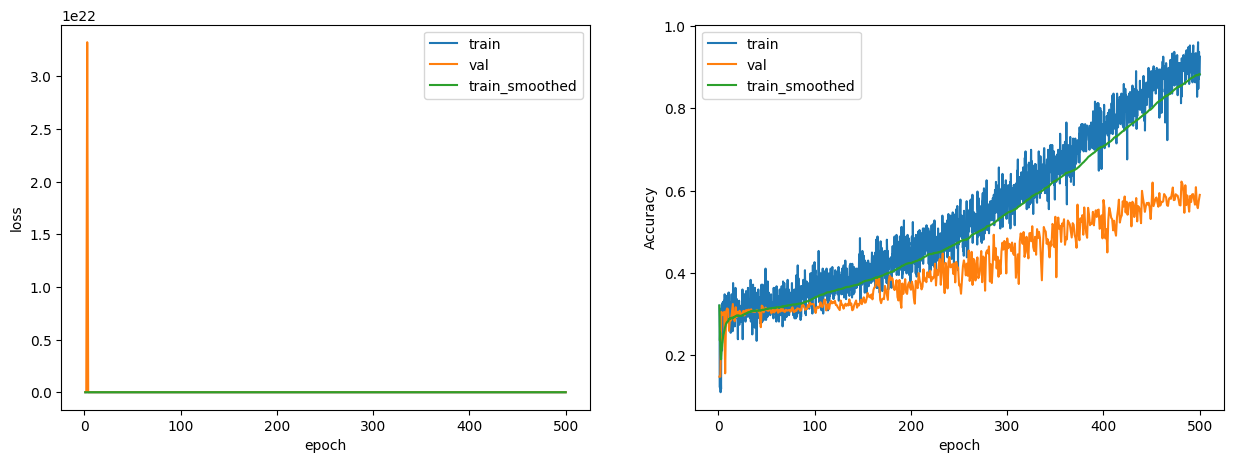

In [13]:
plot_losses(tr_loss_log, tr_acc_log, val_loss_log, val_acc_log)

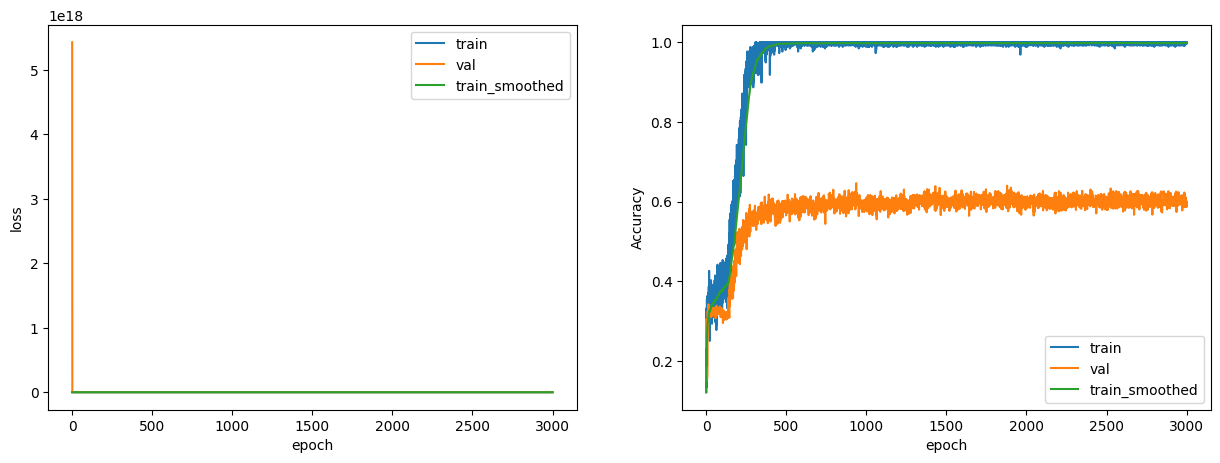

In [17]:
plot_losses(tr_loss_log, tr_acc_log, val_loss_log, val_acc_log)

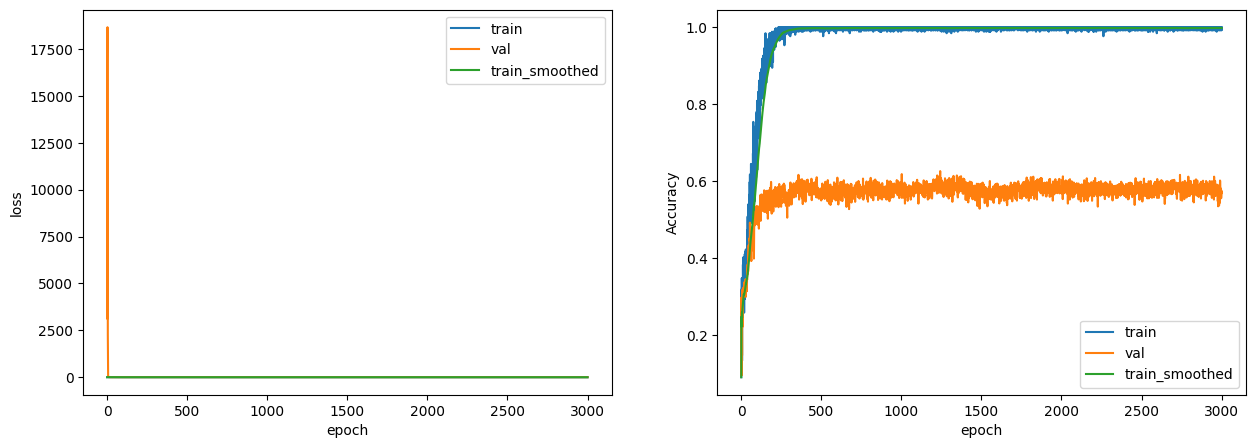

In [26]:
plot_losses(tr_loss_log, tr_acc_log, val_loss_log, val_acc_log)

In [10]:
from torchvision.models import densenet121
model = densenet121(weights=None)
model.features[0] = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.classifier = nn.Linear(model.classifier.in_features, 5)
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [20]:
epochs = 500
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, eta_min=0.0001,)
model.to(device)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(model, optimizer, epochs, train_loader, val_loader, scheduler)

  0%|          | 0/500 [00:00<?, ?it/s]

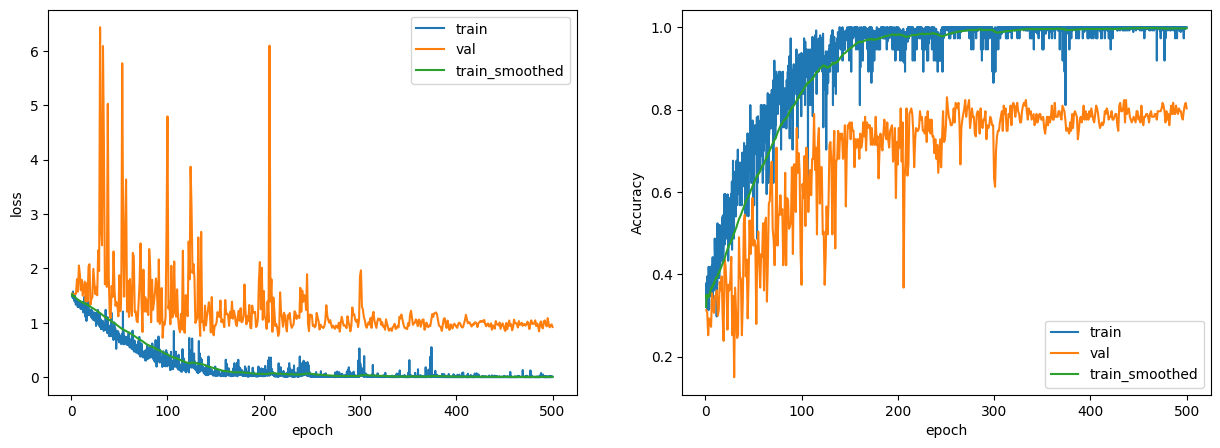

In [21]:
plot_losses(tr_loss_log, tr_acc_log, val_loss_log, val_acc_log)

In [24]:
model = densenet121(weights=None)
model.features[0] = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.classifier = nn.Linear(model.classifier.in_features, 5)
epochs = 500
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, eta_min=0.0001,)
model.to(device)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(model, optimizer, epochs, train_loader, val_loader, scheduler)

  0%|          | 0/500 [00:00<?, ?it/s]

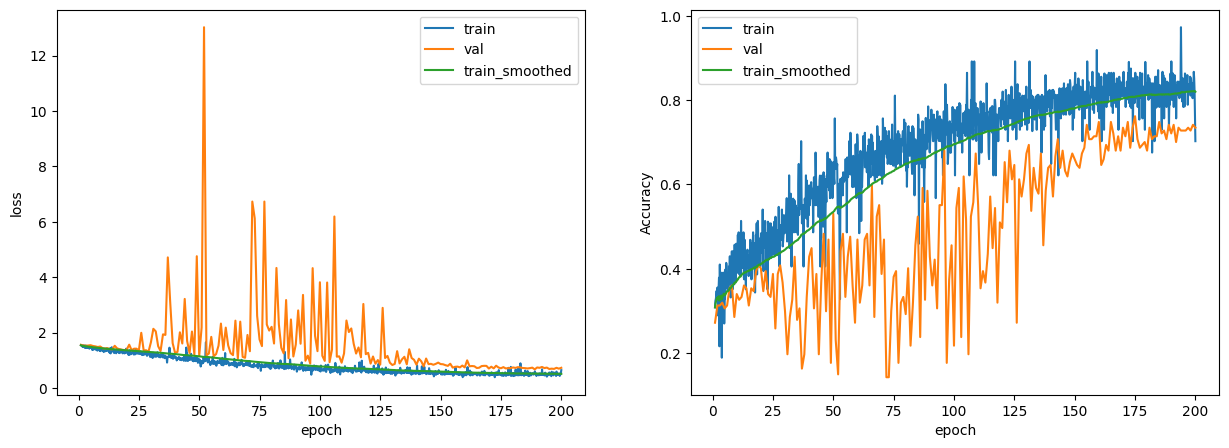

In [23]:
plot_losses(tr_loss_log, tr_acc_log, val_loss_log, val_acc_log)

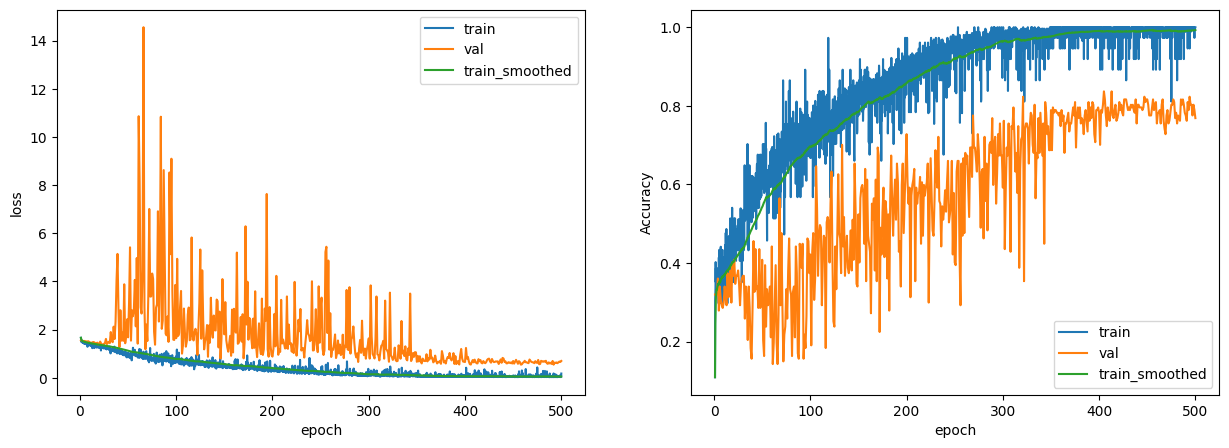

In [25]:
plot_losses(tr_loss_log, tr_acc_log, val_loss_log, val_acc_log)

In [28]:
test(model, test_loader)

(0.08979450290401776, 0.9780061145623525)